In [23]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Camera calibration

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [14]:
# Camera calibration code
def calibrate_camera(x, y, calibration_files):
    """
    Calculate camera matrix and distortion coefficients from chessboard images
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...
    objp = np.zeros((y*x,3), np.float32)
    objp[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    images = glob.glob(calibration_files)
    shape = (None, None)

    # Step through the list of files and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        shape = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return mtx, dist

def correct_distortion(img, mtx, dist):
    """
    Correct image distortion based on camera matrix and distortion coefficients
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

    

## Thresholding functions

In [135]:


def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Apply sobel operator with thresholding.
    
    Return a mask with same size than the original image
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    #        is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    if img.ndim > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = (255*abs_sobel/np.max(abs_sobel)).astype(np.uint8)
    grad_binary = np.zeros_like(scaled_sobel)    
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1    
    return grad_binary

def mag_threshold(imag, sobel_kernel=3, thresh=(0, 255)):
    """
    Compute magniture of gradient, and apply threshold
    
    Return a mask with same size than the original image
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = (255*gradmag/np.max(gradmag)).astype(np.uint8) 
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= thresh[0]) & (scaled_gradmag <= thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= mag_thresh[0]) & (absgraddir <= mag_thresh[1])] = 1
    return dir_binary

def color_threshold(img, channel='R', thresh=(0,255)):
    """
    Threshold based on color channel RGB or HLS
    """
    if channel=='R':
        c = img[:,:,0]
    elif channel=='G':
        c = img[:,:,1]
    elif channel=='B':
        c = img[:,:,2]
    elif channel=='H':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        c = hls[:,:,0] 
    elif channel=='L':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        c = hls[:,:,1]
    elif channel=='S':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        c = hls[:,:,2]
    else:
        c = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    mask = np.zeros_like(c)
    mask[(c >= thresh[0]) & (c <= thresh[1])] = 1
    return mask

In [202]:
def perspective_transform(img):
    """
    """
    src = np.float32([[175,719],[525,500],[788,500],[1120,719]])
    dst = np.float32([[175,719],[175,0],[1120,0],[1120,719]])
    
    M = cv2.getPerspectiveTransform(src, dst)

    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)


## Still Image pipeline

In [203]:
def still_image_pipeline(img, mtx, dist):
    """
    Lane line finding pipeline

    Input: 
        1. original rgb image
        2. camera matrix
        3. distortion coefficients
        
    Output: 
        1. modified image with lane overlay
        2. lane curvature estimation
        3. vehicle position estimation
    """
    curvature = 0.0
    position = 0.0
    
    # Apply a distortion correction to raw images.
    img = correct_distortion(img, mtx, dist)
    
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray = cv2.GaussianBlur(gray,(3, 3),0)
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    sobel = abs_sobel_threshold(img, 'x', 31, (80,180))
    saturation = color_threshold(img, 'S', (160,255))
    mask = np.zeros_like(sobel)
    mask[(sobel==1) | (saturation==1)] = 1

    # Apply a perspective transform to rectify binary image ("birds-eye view").
    warped = perspective_transform(mask)

    # Detect lane pixels and fit to find the lane boundary.

    # Determine the curvature of the lane and vehicle position with respect to center.

    # Warp the detected lane boundaries back onto the original image.
    
    ret = warped
    
    return ret, curvature, position

## Image loop

Loop through test images and add lane overlays

In [19]:
mtx, dist = calibrate_camera(9,6,'camera_cal/calibration*.jpg')

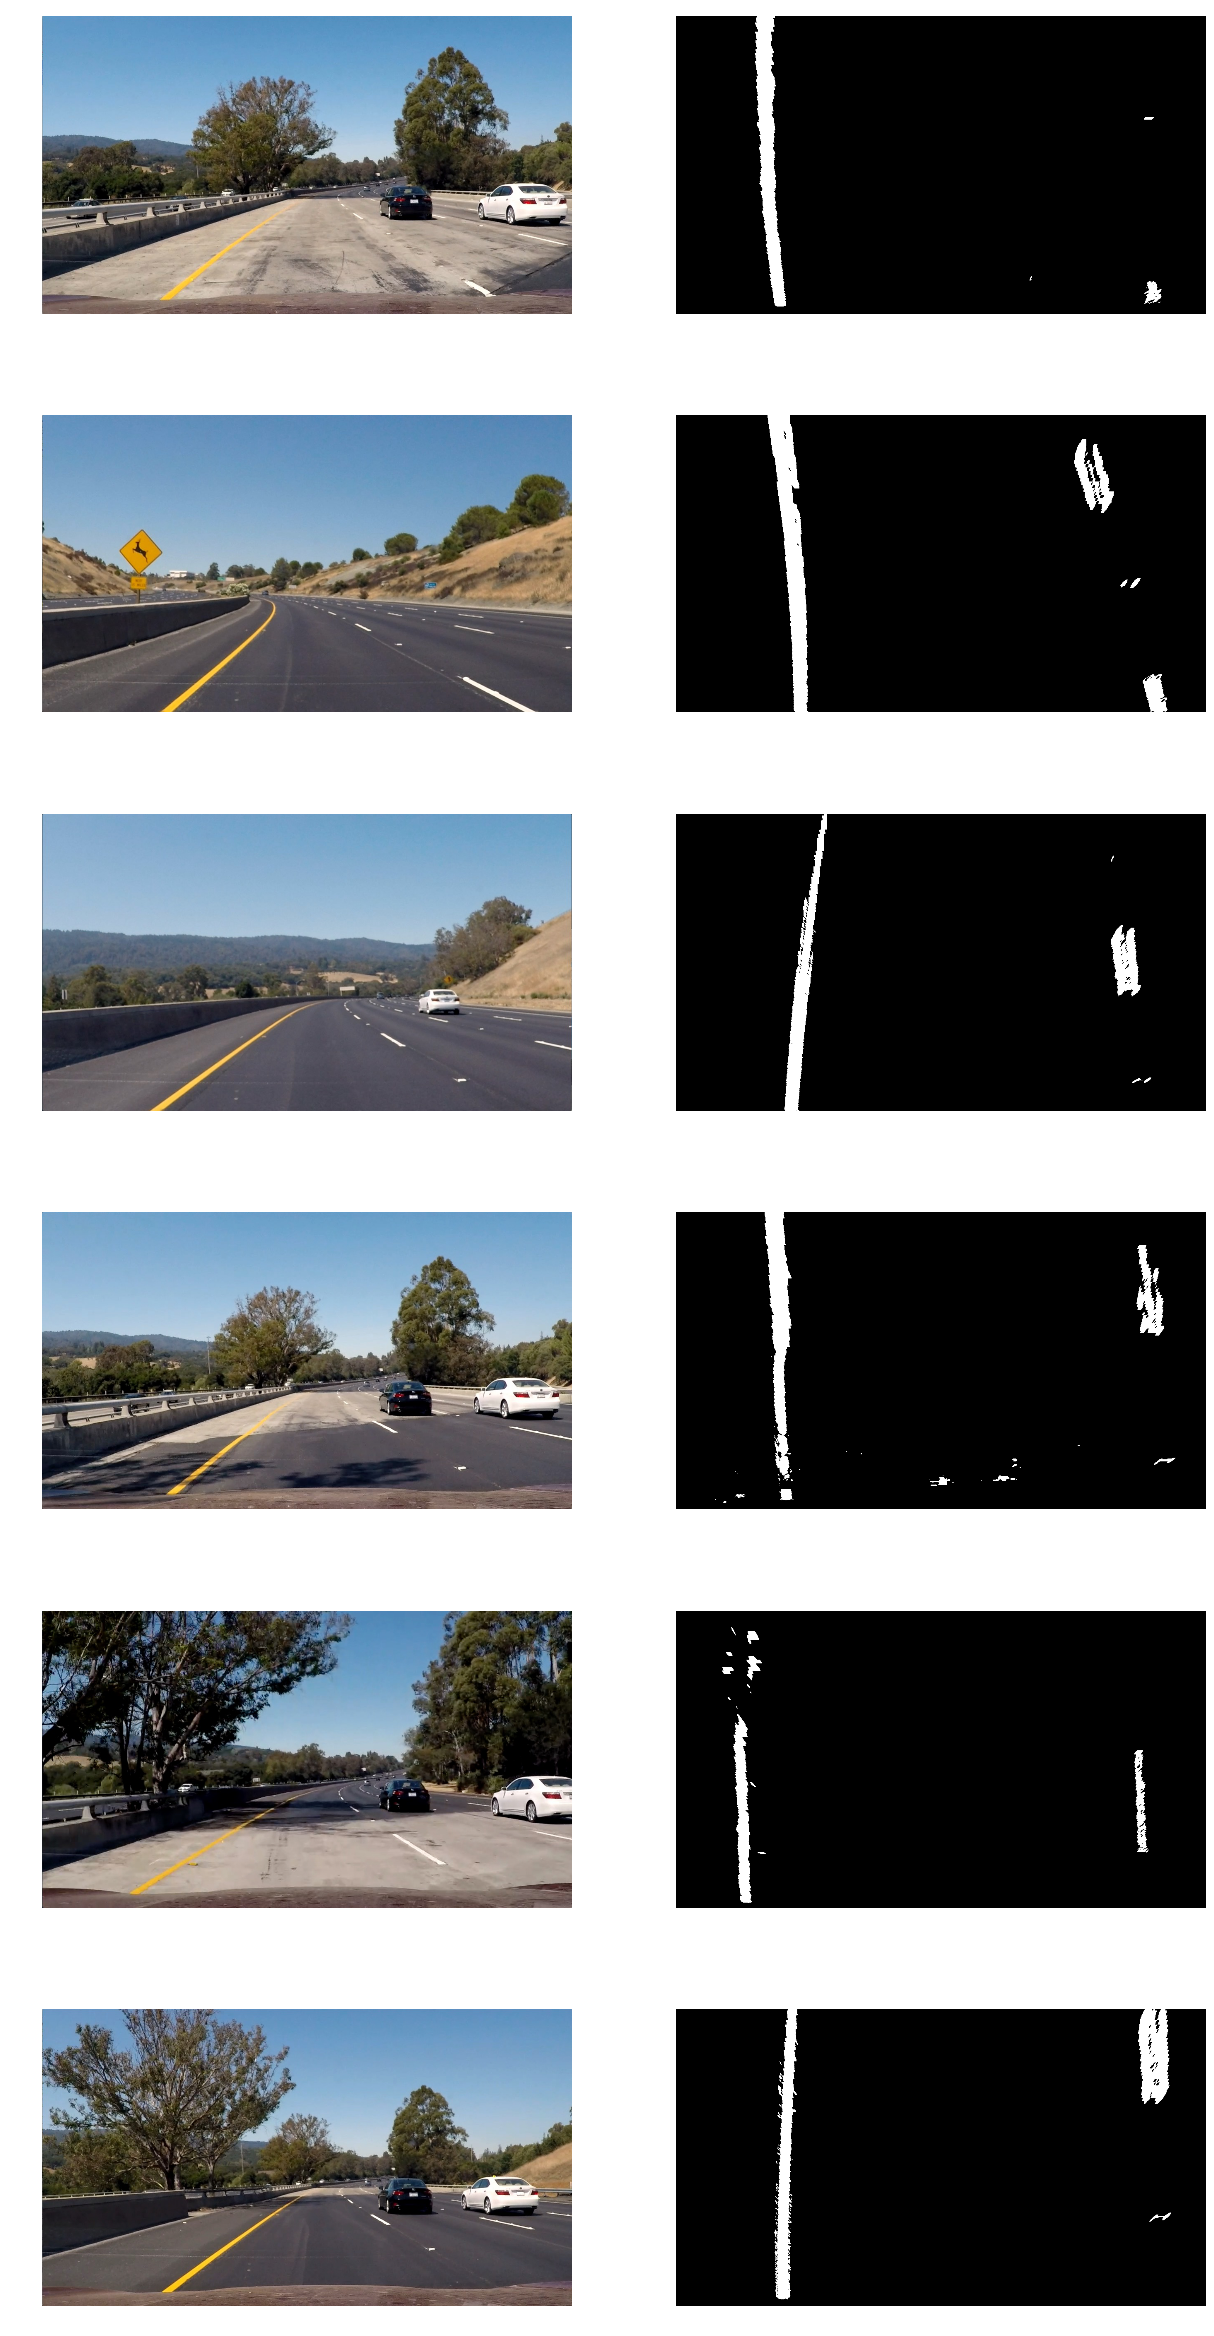

In [204]:
test_images = glob.glob('test_images/test*.jpg')

fig, axes = plt.subplots(6, 2, figsize=(15,30))

for i, fname in zip(range(len(test_images)), test_images):
    img = mpimg.imread(fname);
    axes[i,0].imshow(img)
    axes[i,0].axis('off')
    img2, curv, pos = still_image_pipeline(img, mtx, dist)
    axes[i,1].imshow(img2, cmap='gray')
    axes[i,1].axis('off')

plt.show();

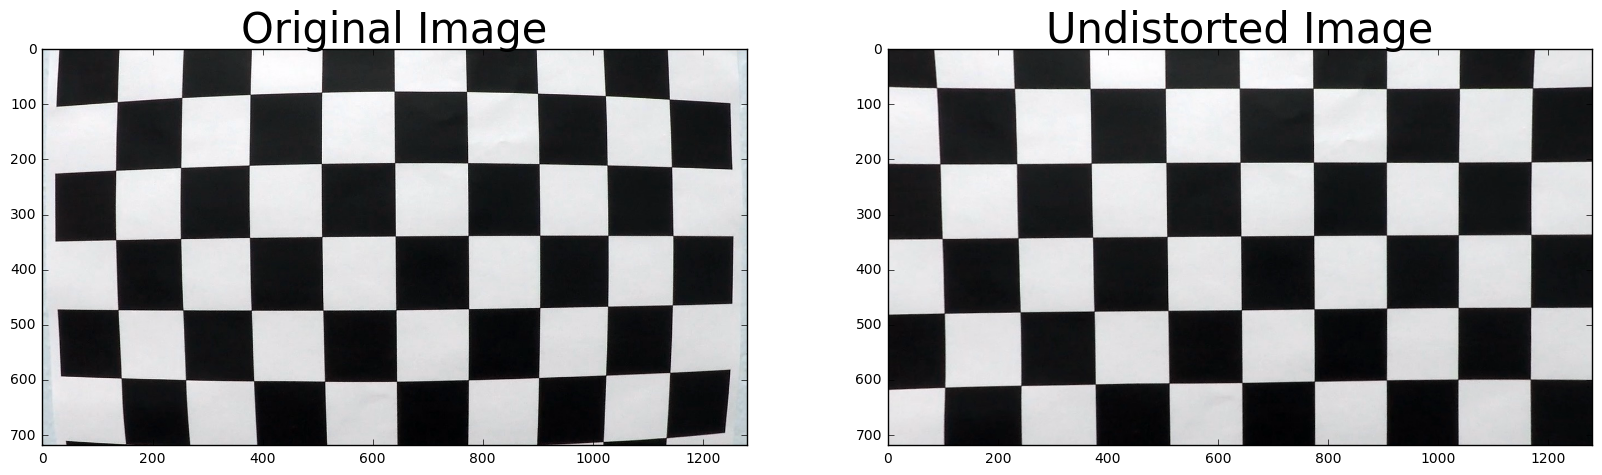

In [12]:
# Visualize undistortion

mtx, dist = calibrate_camera(9,6,'camera_cal/calibration*.jpg')

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_corrected = correct_distortion(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_corrected)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show();

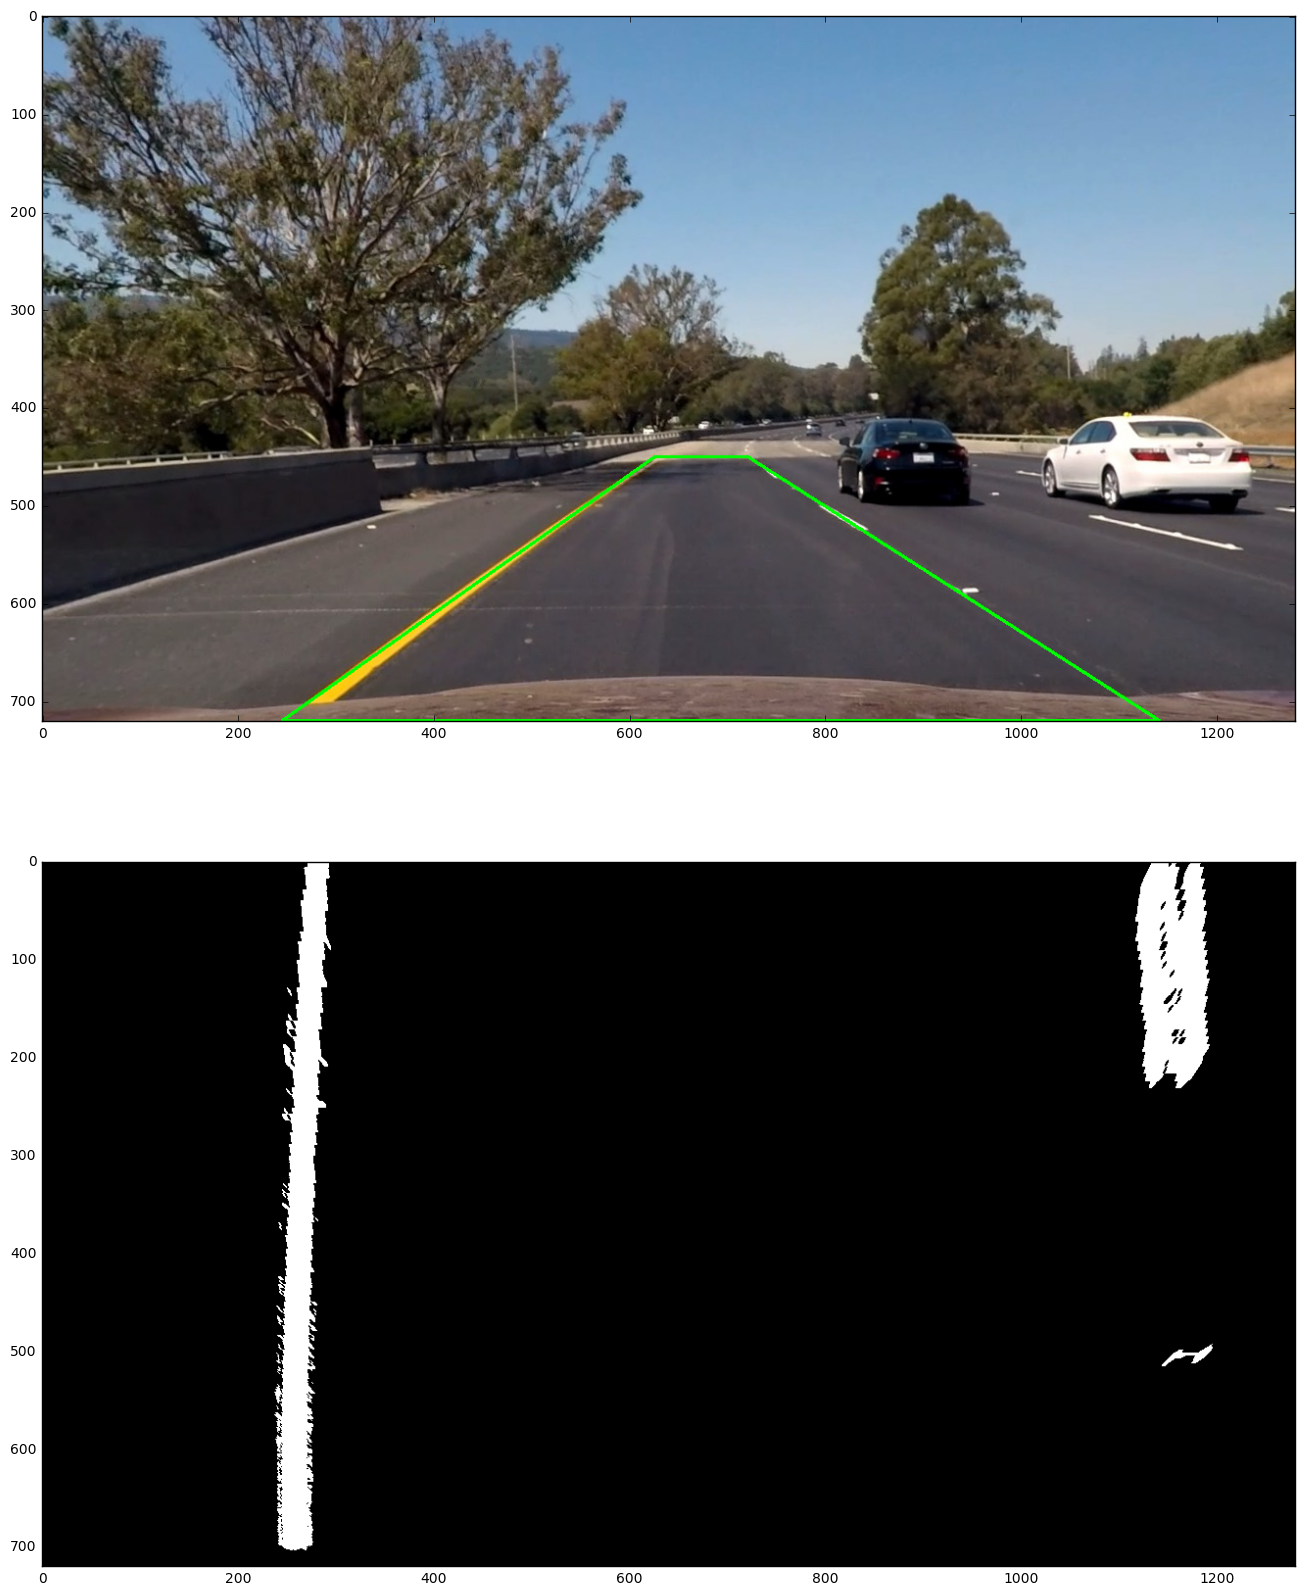

In [220]:
# test perspective transform
def draw_region_of_interest(img, vertices):
    
    #vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)

    color = [0,255,0]
    
    left_bottom = (vertices[0][0][0], vertices[0][0][1])
    left_top = (vertices[0][1][0], vertices[0][1][1])
    right_top = (vertices[0][2][0], vertices[0][2][1])
    right_bottom = (vertices[0][3][0], vertices[0][3][1])

    bottom_center = ((right_bottom[0]+left_bottom[0])//2, right_bottom[1])
    top_center = ((right_top[0]+left_top[0])//2, right_top[1])

    
    cv2.line(img, left_bottom, left_top, color, 2)
    cv2.line(img, left_top, right_top, color, 2)
    cv2.line(img, right_top, right_bottom, color, 2)
    cv2.line(img, right_bottom, left_bottom, color, 2)
    #cv2.line(img, bottom_center, top_center, color, 2)
    
img = mpimg.imread('test_images/test6.jpg')
img = correct_distortion(img, mtx, dist)

#src = np.float32([[245,719],[625,450],[720,450],[1140,719]])
#dst = np.float32([[245,719],[245,100],[1140,100],[1140,719]])
src = np.float32([[175,719],[525,500],[788,500],[1120,719]])
dst = np.float32([[175,719],[175,0],[1120,0],[1120,719]])

M = cv2.getPerspectiveTransform(src, dst)

sobel = abs_sobel_threshold(img, 'x', 31, (80,180))
saturation = color_threshold(img, 'S', (160,255))
mask = np.zeros_like(sobel)
mask[(sobel==1) | (saturation==1)] = 1

warped = cv2.warpPerspective(mask, M, (mask.shape[1],mask.shape[0]), flags=cv2.INTER_LINEAR)

draw_region_of_interest(img, [[(245,719),(625,450),(720,450),(1140,719)]])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

ax1.imshow(img)
ax2.imshow(warped, cmap='gray')

plt.show();

<function __main__.plt_gradx>

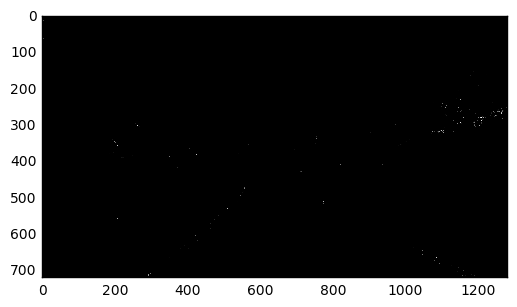

In [145]:
# test gradient combinations

from ipywidgets import widgets



def plt_gradx(sobel_mn, sobel_mx, ksize, color_mn, color_mx):
    gradx = abs_sobel_threshold(img, orient='x', sobel_kernel=ksize, thresh=(sobel_mn,sobel_mx))
    col = color_threshold(img, 'S', (color_mn,color_mx))
    mask = np.zeros_like(col)
    mask[(col==1) | (gradx==1)] = 1
    f, ax = plt.subplots(1,1)
    ax.imshow(mask,cmap='gray');

img = mpimg.imread('test_images/test2.jpg')
                                                 
widgets.interact(plt_gradx, sobel_mn=(0,255,1), sobel_mx=(0,255,1), ksize=(3,31,2), color_mn=(0,255), color_mx=(0,255))    